# Discrete Fourier Transform

$$ D_k(z) = \sum_{j=0}^{n-1}z_j e^{-\frac{2i \pi j k}{n}} $$

$$ D_k^{-1}(z) = \frac{1}{n}\sum_{j=0}^{n-1}z_j e^{\frac{2i \pi j k}{n}} $$

https://www.davidhbailey.com/dhbpapers/fracfft.pdf

https://www.davidhbailey.com/dhbpapers/fourint.pdf

In [1]:
import numpy as np

def dft(Z):
    n = len(Z)
    L = np.zeros_like(Z, dtype=complex)
    for k in range(n):
        for j in range(n):
            L[k] += Z[j]*np.exp(-2*1j*np.pi*j*k/n)
    return L

def idft(Z):
    n = len(Z)
    L = np.zeros_like(Z, dtype=complex)
    for k in range(n):
        for j in range(n):
            L[k] += (1/n) * Z[j] * np.exp(2*1j*np.pi*j*k/n)
    return L

Error :  6.069270725473981e-14


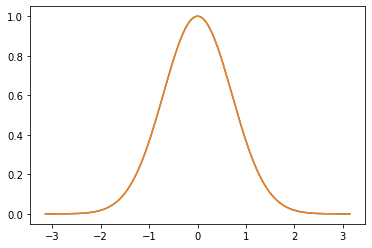

In [2]:
import matplotlib.pyplot as plt

def error(y, x):
    e = max(abs(x - y))/max(abs(x))
    print("Error : ", e)

x = np.linspace(-np.pi, np.pi, 256)
y = np.exp(-x*x)
z_dft = dft(y)
y_dft = idft(z_dft)
plt.plot(x, y)
plt.plot(x, y_dft.real)

error(y_dft, y)

# Fast Fourier Transform

In [3]:
def fft(Z):
    n = len(Z)
    if n <= 1:
        return Z.copy()
    else:
        assert(n % 2 == 0)
        even = fft(Z[::2])
        odd = fft(Z[1::2])
        result = np.zeros_like(Z, dtype=complex)
        factors = np.exp(-2*1j*np.pi*np.arange(n//2)/n)
        result[:n//2] = even + factors * odd
        result[n//2:] = even - factors * odd
        return result
    
def ifft(Z):
    n = len(Z)
    if n <= 1:
        return Z.copy()
    else:
        assert(n % 2 == 0)
        even = ifft(Z[::2])
        odd = ifft(Z[1::2])
        result = np.zeros_like(Z, dtype=complex)
        factors = np.exp(2*1j*np.pi*np.arange(n//2)/n)
        result[:n//2] = even + factors * odd
        result[n//2:] = even - factors * odd
        return (1/2) * result

In [4]:
z_fft = fft(y)
error(z_fft, z_dft)

Error :  2.5702159667530204e-14


Error :  3.435810579911361e-16


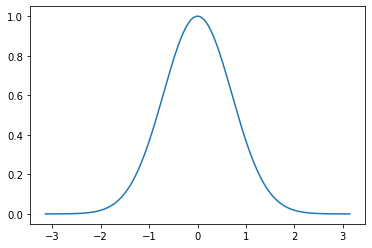

In [5]:
y_fft = ifft(z_fft)
plt.plot(x, y_fft.real)
error(y_fft, y)

In [6]:
from numpy.fft import fft, ifft

# Circular Discrete Convolution

Les séquences sont de longueur $n$ et les indices sont vu dans $Z/nZ$.

$$ (x*y)(k) = \sum_{j=0}^{n-1}x_j y_{k-j}  $$


In [7]:
def conv(x, y):
    assert(len(x) == len(y))
    n = len(x)
    L = np.zeros_like(x)
    for k in range(n):
        for j in range(n):
            L[k] += x[j] * y[(k-j)%n]
    return L

In [8]:
def conv_fft(x, y):
    assert(len(x) == len(y))
    return ifft(fft(x) * fft(y))

Error :  1.2572539723623029e-15


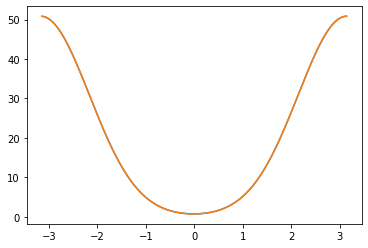

In [9]:
c = conv(y, y)
c_fft = conv_fft(y, y)
plt.plot(x, c)
plt.plot(x, c_fft.real)
error(c_fft, c)

# Fractional Fourier Transform

$$ G_k(x, \alpha)= \sum_{j=0}^{n-1}x_je^{-2i\pi jk\alpha} = e^{-i\pi k^2 \alpha} \sum_{j=0}^{n-1}y_jz_{k-j}$$

avec

$$ y_j = x_je^{-i\pi j^2 \alpha} \text{  et  } z_j = e^{i\pi j^2 \alpha} $$ 

Attention, $z_{k-j} \neq z_{n+k-j}$ : on ne peut pas utiliser directement une convolution discrète circulaire.

In [10]:
def frac_dft(X, a):
    n = len(X)
    L = np.zeros_like(X, dtype=complex)
    for k in range(n):
        for j in range(n):
            L[k] += X[j]*np.exp(-2*1j*np.pi*j*k*a)
    return L

def frac_fft(X, a):
    n = len(X)
    j = np.arange(n)
    y = X * np.exp(-1j*np.pi*j*j*a)
    z = np.exp(1j*np.pi*j*j*a)
    
    Y = np.zeros(2*n, dtype=complex)
    Z = np.zeros(2*n, dtype=complex)
    Y[:n] = y
    Z[:n] = z
    Z[n+1:] = z[:0:-1]
    return np.exp(-1j*np.pi*j*j*a) * conv_fft(Y, Z)[:n]

In [11]:
z_frac_dft = frac_dft(y, 1/len(x))
y_frac_dft = frac_dft(z_frac_dft, -1/len(x))/len(x)
error(z_frac_dft, z_dft)
error(y_frac_dft, y)
error(frac_fft(y, np.sqrt(5)), frac_dft(y, np.sqrt(5)))

Error :  0.0
Error :  6.069270725473981e-14
Error :  8.282161898430233e-12


# Continuous Fourier Transform

$f$ est nulle hors de $[-\frac{a}{2}, \frac{a}{2}]$

$$ F(x) = \int_{-\infty}^{+\infty} f(t)e^{-itx}dt = \int_{-\frac{a}{2}}^{+\frac{a}{2}} f(t)e^{-itx}dt $$

$f$ est connue en $n$ points répartis uniformément sur $[-\frac{a}{2}, \frac{a}{2}]$, i.e $t_k=-\frac{a}{2} + k \frac{a}{n}$ pour $0 \le k < n$.

On souhaite évaluer $F$ en $n$ points répartis uniformément sur $[-\frac{b}{2}, \frac{b}{2}]$, i.e $x_k=-\frac{b}{2} + k \frac{b}{n}$ pour $0 \le k < n$.

$$ F(x_k) = \int_{-\frac{a}{2}}^{+\frac{a}{2}} f(t)e^{-itx_k}dt 
          = \frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-it_jx_k}
          = \frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-i(-\frac{a}{2} + j \frac{a}{n})x_k} $$
$$        = e^{i\frac{a}{2}x_k}\frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-i j \frac{a}{n}x_k}
          = e^{i\frac{a}{2}x_k}\frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-i j \frac{a}{n}(-\frac{b}{2} + k\frac{b}{n})}
          = e^{i\frac{a}{2}x_k}\frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{i j \frac{a}{n}\frac{b}{2}}e^{-i j \frac{a}{n} k\frac{b}{n}}
$$ 

On reconnait une transformée fractionnaire avec $-i j \frac{a}{n} k\frac{b}{n} = -2i\pi jk\alpha$ soit 
$\frac{a}{n} \frac{b}{n} = 2\pi \alpha$ soit
$\alpha = \frac{ab}{2\pi n^2}$

$$ F(x_k) = e^{i\frac{a}{2}(-\frac{b}{2} + k \frac{b}{n})}\frac{a}{n} G_k\left(\left( f(-\frac{a}{2} + j \frac{a}{n})e^{i j \frac{ab}{2n}}\right)_{0 \le j < n}, \alpha\right) $$ 

In [12]:
def cft(u, a, b, n):
    result = np.zeros(n, dtype=complex)
    for k in range(n):
        for j in range(n):
            tj = -a/2 + j*a/n
            xk = -b/2 + k*b/n
            result[k] += a/n*u[j]*np.exp(-1j*tj*xk)
    return result

def cfft(u, a, b, n):
    k = np.arange(n)
    xk = -b/2 + (b/n)*k
    
    prefactor = (a/n) * np.exp(1j*(a/2)*xk)
    y = u * np.exp(1j*a*b/(2*n)*k)
    alpha = a*b / (2*np.pi*n*n)
    
    return prefactor * frac_fft(y, alpha)

def icfft(u, a, b, n):
    j = np.arange(n)
    tj = -a/2 + (a/n)*j
    
    prefactor = (b/2/np.pi/n) * np.exp(-1j*(b/2)*tj)
    y = u * np.exp(-1j*a*b/(2*n)*j)
    alpha = a*b / (2*np.pi*n*n)
    
    return prefactor * frac_fft(y, -alpha)

Error :  5.751925482141584e-07
Error :  3.281477755994373e-15


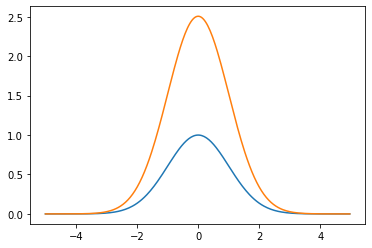

Error :  1.3764003965444684e-06


In [13]:
a = 10
b = 10
n = 256

tk = -a/2 + (a/n)*np.arange(n)
xk = -b/2 + (b/n)*np.arange(n)
u = np.exp(-tk*tk/2)

u_hat = cfft(u, a, b, n)
error(cft(u, a, b, n), np.sqrt(2*np.pi)*u) # Simpson would be better
error(u_hat, cft(u, a, b, n))

plt.plot(tk, u)
plt.plot(xk, u_hat.real)
plt.show()

u_back = icfft(u_hat, a, b, n)
error(u_back, u)

# Problèmes avec la contrainte

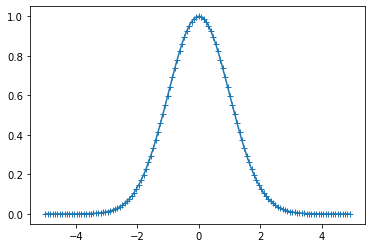

80.4247719318987


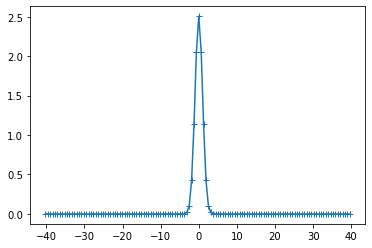

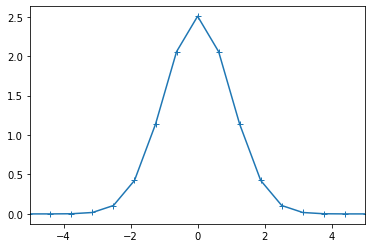

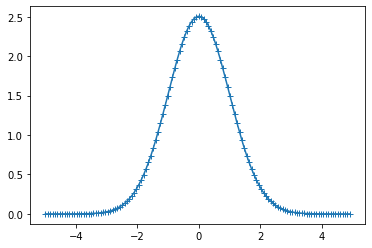

In [14]:
def save_to_file(t, u, name):
    n = len(t)
    with open(name, 'w') as f:
        f.write("X Y\n")
        f.writelines([str(t[i]) + " " + str(u[i]) + "\n" for i in range(n)])

a = 10
n = 128

# u est une gaussienne
t = a/n*np.arange(n) - a/2
u = np.exp(-t**2/2)
save_to_file(t, u.real, "gaussienne_entree.txt")
plt.plot(t, u, '-+')
plt.show()

# Calcul de la transformée de u
b = 2*np.pi*n/a
print(b)
x = b/n*np.arange(n) - b/2
SHIFT = (-1)**np.arange(n)
u_hat = a/n * (-1j)**n * SHIFT * fft(SHIFT * u)
save_to_file(x, u_hat.real, "gaussienne_sortie.txt")
plt.plot(x, u_hat.real, '-+')
plt.show()

# Centré
plt.plot(x, u_hat.real, '-+')
plt.xlim(-5, 5)
plt.show()

# CFFT
u_hat_bis = cfft(u, a, 10, n)
save_to_file(t, u_hat_bis.real, "gaussienne_sortie_bis.txt")
plt.plot(t, u_hat_bis.real, '-+')
plt.show()

# Dérivation FrFFT

Error :  1.9088801331022364e-12


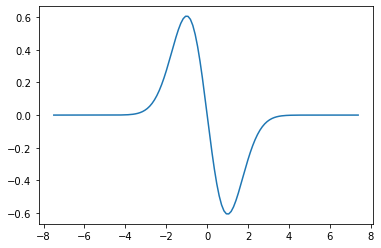

In [15]:
def deriv(u, a, b):
    n = len(u)
    u_hat = cfft(u, a, b, n)
    xk = -b/2 + (b/n)*np.arange(n)
    u_hat *= 1j * xk
    return icfft(u_hat, a, b, n)

a = 15
n = 128
t = a/n*np.arange(n) - a/2
u = np.exp(-t**2/2)
up = deriv(u, a, a).real
save_to_file(t, up, "gaussienne_derivee.txt")
error(up, -t*np.exp(-t**2/2))
plt.plot(t, up)
plt.show()

# Équation de Schrödinger non-linéaire

$$ \frac{\partial u}{\partial z}(z, t) = - i\frac{\text{sign}(\beta_2)}{2} \frac{\partial^2 u}{{\partial t}^2}(z, t) + iN^2u(z, t)|u(z, t)|^2$$

## Split-Step method :

$$ \frac{\partial u}{\partial z}(z, t) = - i\frac{\text{sign}(\beta_2)}{2} \frac{\partial^2 u}{{\partial t}^2}(z, t)$$

Donc en prenant la transformée de Fourier en $t$ :

$$ \frac{\partial \hat{u}}{\partial z}(z, \nu) 
= - i\frac{\text{sign}(\beta_2)}{2} (i\nu)^2 \hat{u}(z, \nu)
= i\frac{\text{sign}(\beta_2)}{2} \nu^2 \hat{u}(z, \nu)
$$

$$ \hat{u}(z + h, \nu) 
= e^{i\frac{\text{sign}(\beta_2)}{2} \nu^2 h}\hat{u}(z, \nu)
$$

In [16]:
# Affichage de u
def plot_time_and_freq(u, t, u_hat, nu, freqsize=None, timesize=None):
    fig, (ax_time, ax_freq) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax_time.plot(t, np.abs(u)**2)
    ax_time.set_xlabel("Time (t)")
    ax_time.set_ylabel("|u(t)|")
    ax_time.set_title("Time domain plot of u")
    if timesize != None:
        ax_time.set_xlim(-timesize/2, timesize/2)
        
    ax_freq.plot(nu, np.abs(u_hat)**2, '-+')
    ax_freq.set_xlabel("Frequency (nu)")
    ax_freq.set_ylabel("|û(nu)|")
    ax_freq.set_title("Frequency domain plot of u")
    if freqsize != None:
        ax_freq.set_xlim(-freqsize/2, freqsize/2)
    
    plt.show()

In [23]:
# Paramètres de la simulation

N = 3 # Paramètre de la non-linéarité
sign_beta = -1 # Normal (1) or anomalous (-1) dispersion

T = 17 # Amplitude temporelle
Nt = 512 # Nombre de points de la FFT

Nz = 1000 # Nombre total d'itérations
L = 5 # Longueur de la fibre

t = np.arange(Nt)*T/Nt - T/2 # Grille temporelle
h = L / Nz # Pas spatial

# Signal en entrée de la fibre
u0 = np.exp(-t*t/2) 

display_freq = 20 # [-s/2, s/2], Utilisé pour l'affichage
display_time = 6

# Utilisation de la FFT

FreqAmp :  189.23475748682048


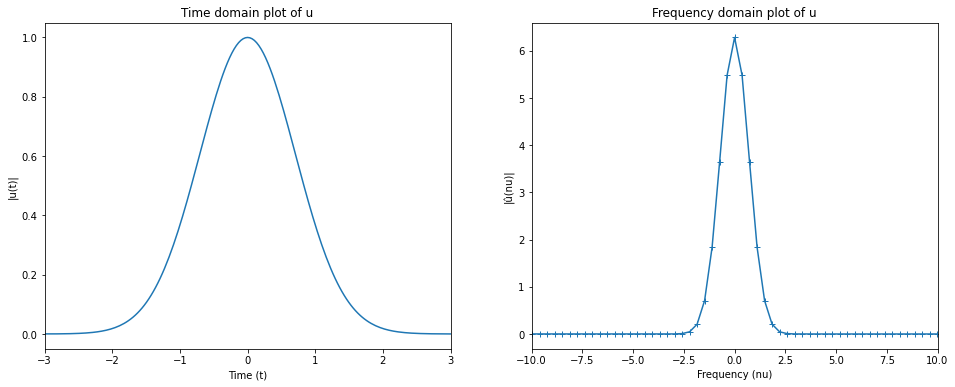

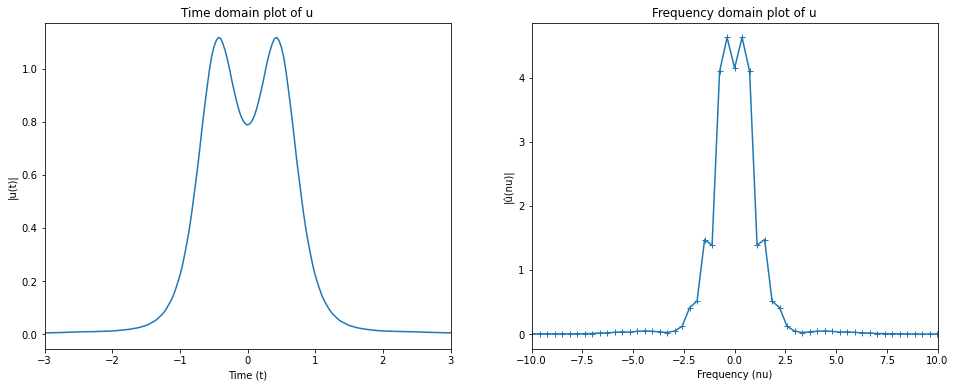

In [24]:
# Détermine les fréquences induites par la FFT
FreqAmp = 2*np.pi*Nt/T
print("FreqAmp : ", FreqAmp)
nu = np.arange(Nt)*FreqAmp/Nt - FreqAmp/2

# Opérateurs à l'exécution
SHIFT = (-1)**np.arange(Nt)
CONST = T/Nt * (-1j)**Nt
DIFFUSE = np.exp(1j * sign_beta / 2 * h * nu**2)

# Affichage initial
u0_hat = CONST * SHIFT * fft(SHIFT*u0)
plot_time_and_freq(u0, t, u0_hat, nu, freqsize = display_freq, timesize = display_time)
save_to_file(t, np.abs(u0)**2, "FFT_u_entree.txt")
save_to_file(nu, np.abs(u0_hat)**2, "FFT_uhat_entree.txt")


u = u0
for i in range(Nz):
    u = u * np.exp(1j * N*N * h/2  * np.abs(u)**2) # Demi itération non linéaire
    u_hat = CONST * SHIFT * fft(SHIFT*u) # Passage en Fourier
    u_hat = DIFFUSE * u_hat # Diffusion
    u = ifft(u_hat / CONST * SHIFT) * SHIFT # Retour en temporel
    u = u * np.exp(1j * N*N * h/2  * np.abs(u)**2) # Demi itération non linéaire
    
# Affichage final
u_hat = CONST * SHIFT * fft(SHIFT*u)
plot_time_and_freq(u, t, u_hat, nu, freqsize = display_freq, timesize = display_time)
save_to_file(t, np.abs(u)**2, "FFT_u_sortie.txt")
save_to_file(nu, np.abs(u_hat)**2, "FFT_uhat_sortie.txt")

# Utilisation de la FrFFT

FreqAmp :  100


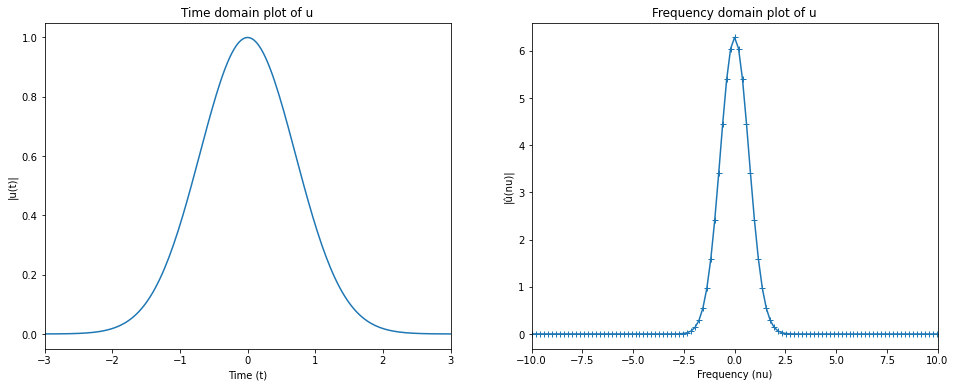

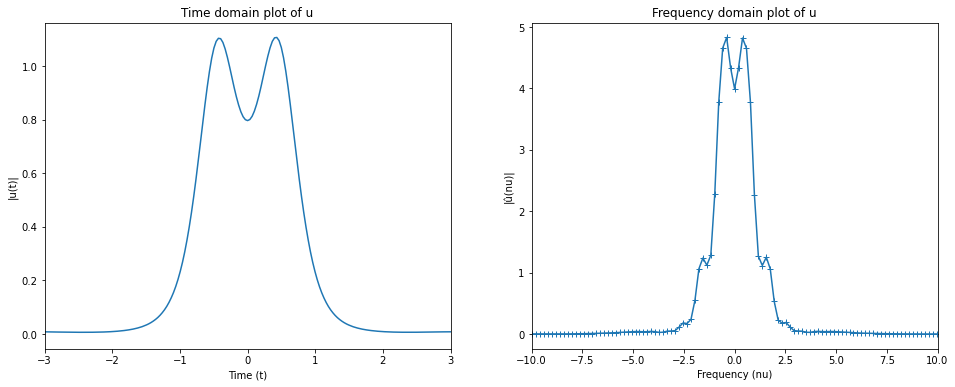

In [27]:
# Détermine les fréquences induites par la FFT
FreqAmp = 100
print("FreqAmp : ", FreqAmp)
nu = np.arange(Nt)*FreqAmp/Nt - FreqAmp/2

# Opérateurs à l'exécution
DIFFUSE = np.exp(1j * sign_beta / 2 * h * nu**2)

# Affichage initial
u0_hat = cfft(u0, T, FreqAmp, Nt)
plot_time_and_freq(u0, t, u0_hat, nu, freqsize = display_freq, timesize = display_time)
save_to_file(t, np.abs(u0)**2, "FrFFT_u_entree.txt")
save_to_file(nu, np.abs(u0_hat)**2, "FrFFT_uhat_entree.txt")

u = u0
for i in range(Nz):
    u = u * np.exp(1j * N*N * h/2  * np.abs(u)**2) # Demi itération non linéaire
    u_hat = cfft(u, T, FreqAmp, Nt)
    u_hat = DIFFUSE * u_hat # Diffusion
    u = icfft(u_hat, T, FreqAmp, Nt)
    u = u * np.exp(1j * N*N * h/2  * np.abs(u)**2) # Demi itération non linéaire
    
# Affichage final
u_hat = cfft(u, T, FreqAmp, Nt)
plot_time_and_freq(u, t, u_hat, nu, freqsize = display_freq, timesize = display_time)
save_to_file(t, np.abs(u)**2, "FrFFT_u_sortie.txt")
save_to_file(nu, np.abs(u_hat)**2, "FrFFT_uhat_sortie.txt")